#**Project Suggestion:** 
#**Predicting stocks prices with social media (Reddit) traffic**

##Introduction:

For centuries, traders have tried to predict stock market trends to maximize their profits. The myth says that even the founder of the Rothschild family gained his fortune by using mail pigeons, which allowed him to be the first in London to know that the British won the Waterloo battle, allowing him to purchase English stocks at low prices.

Stock markets today have become extremely complex and interactive. As a result, it is nearly impossible to predict what will happen. In order to gain fractions on small arbitrages, many companies pay fortunes to place their servers physically close to the market.

We are attempting to reduce the problem of stock price forecasting to an easier one in a small case with specific stocks.

Recently, and especially last year (as a result of the Coronavirus), a new phenomenon has emerged. Millions of small investors rely on social media traffic for their investments in the stock market. There is a small list of stocks called "Meme Stocks", which are especially associated with this phenomenon.
Meme stocks are real stocks, that have gained popularity due some online trend in social media, as if the stock has gone viral like a meme.

At the January 2021 a short squeeze of the stock of the American video game retailer GameStop (GME) took place, cuasing major financail consequences and vast changes in the stock's value. At its height, on January 28, the short squeeze caused the retail's stock price to reach a pre-market value of over 500 US$ per share, neary 30 times the valuation of the beginning of the month.

The short squeeze was initially and primarily triggered by users of the subreddit r/wallstreetbets. The unusually high price and volatility have continued after the peak in late January. And, the phenomenon of big amounts of small-scale brokerages using app-based brokerage services such as "Robinhood" that investing by the traffic in social media has expanded. Not only by trading over the GME stock but also on other stock memes.

Our project aims to predict a daily change in meme stock prices based on traffic on Reddit. Specifically on the r/wallstreetbets page. We are focusing on a period of half a 
year, after the GME's short squeeze.

We chose to examine three of the top meme stocks that were in the headlines over the last 2 years: GME (GameStop), AMC (AMC Entertainment) and NOK (Nokia)

### A typical post on a stock in Reddit:
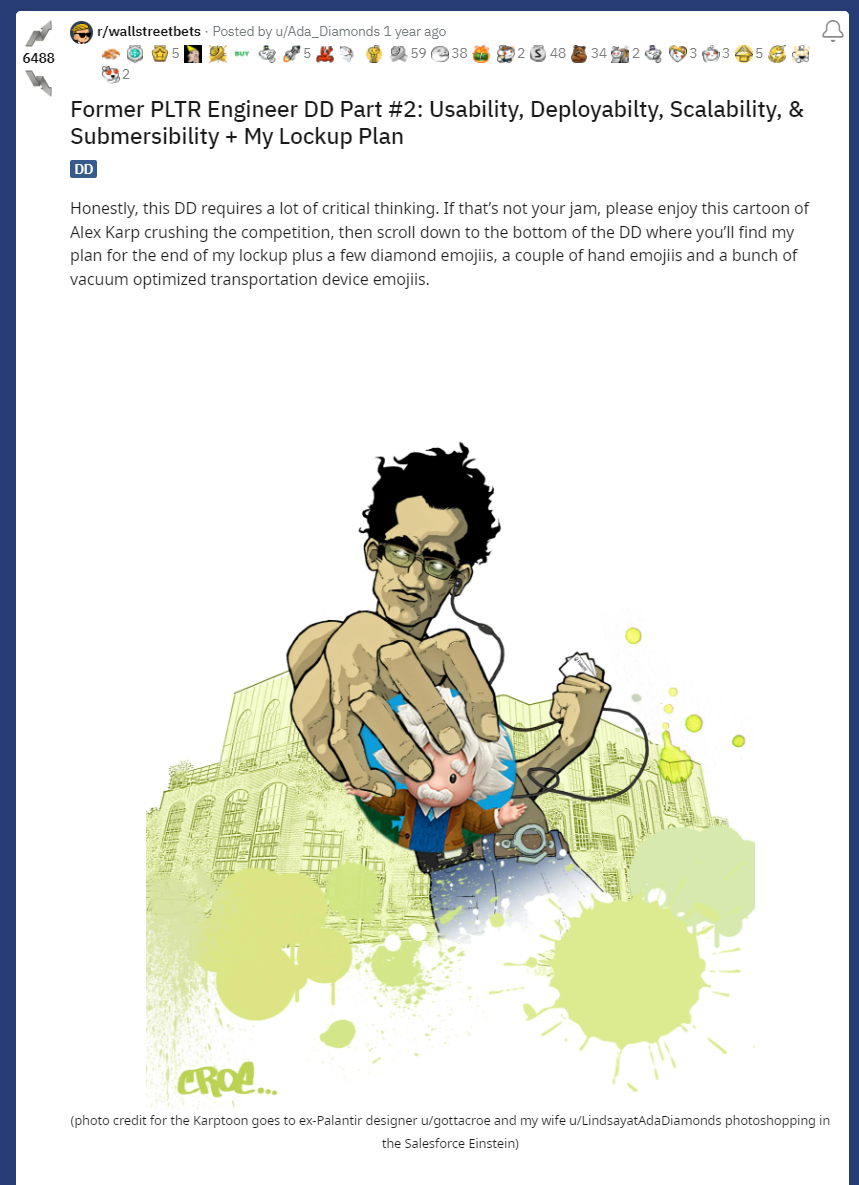

We can see that a post on Reddit typically contains the following data:


*  emojis attached to the posed
*  social media slang language, using many unformal words and emojis.
*  Images, gifs, videos, and links attached to the post,
*  post's score - simply the number of upvotes minus the number of downvotes
*  Number of comments other users wrote in the post 

We will use that data as features and for making new ones for our model



##imports and aux functions

In [ ]:
!pip install prophet
!pip install vaderSentiment
!pip install yfinance

In [ ]:
from google.colab import drive
from prophet import Prophet
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
from gensim.models.doc2vec import Doc2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import plotly
import notebook
import ipywidgets
from prophet.plot import plot_plotly, plot_components_plotly
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
nltk.download('stopwords')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def FB_prophet(stock, start_period, training_untill, end_period, days_to_forecast):
  stock_df = yf.Ticker( stock )
  stock_df = stock_df.history(start = start_period, end = end_period)
  stock_df.reset_index(inplace=True)
  stock_df = stock_df[['Date','Close']].rename(columns= {'Date': 'ds', 'Close': 'y'})
  m = Prophet(daily_seasonality=True)
  history_df = stock_df[ stock_df['ds'] <= training_untill ]
  m.fit(history_df)
  future_df = m.make_future_dataframe( periods = days_to_forecast, freq ='d', include_history = True )
  future_df = future_df[ future_df['ds'].isin( stock_df['ds'] ) ]
  return m, m.predict(future_df), stock_df

In [ ]:
def multy_ROC_curve_one_graph(y_test, y_score, labels ):
  n_class = 2 if len(y_train[y_train == "no change"]) == 0 else 3
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = {}
  colors = ['orange', 'green', 'blue','red','purple','brown', 'pink','gray','olive','cyan']
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_score[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i],
             label=( '{0}'.format(labels[i])))
  
  plt.plot([0, 1], [0, 1], color="navy", linestyle="-", label='random clf')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.figure(figsize=(8, 6), dpi=80)
  plt.show()   

In [ ]:
def get_metrices(y_test, prediction):
  cf_matrix = confusion_matrix(y_test, prediction)
  cl_report = classification_report(y_test, prediction)
  acc_score = accuracy_score(y_test, prediction) * 100
  return cf_matrix, cl_report, acc_score

In [ ]:
def plot_confusion_matrix(cf_matrix, title):
  fig, ax = plt.subplots(figsize=(15,10))
  ax = sns.heatmap(cf_matrix, annot=True, linewidths=1, cmap='coolwarm', fmt='g', mask=cf_matrix<1)
  ax.set_facecolor('xkcd:black')
  ax.set(title=title)
  ax.plot()

In [ ]:
def roc_curve_PC(clf, X_train, y_train):
  clf = OneVsRestClassifier(clf)
  clf = clf.fit(X_train, y_train)
  y_score =clf.predict_proba(X_test)
  labels=['negative', 'positive', 'no change']
  y_b = y_test.apply(lambda x : 0 if x == 'negative' else 1 if x == 'positive' else 2).values
  multy_ROC_curve_one_graph(y_b, y_score, labels)

In [ ]:
def stock_date_show(stock_df, stock_name):
  date_to_show = []
  i = 0
  dates_range = len(stock_df)
  while i<=dates_range:
    date_to_show.append(stock_df['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(stock_df['Date'].iloc[dates_range-1])
  x = stock_df['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), stock_df['Open'])
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Stock Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock Values', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [ ]:
def normialized_sentiment_value_show(df, stock_df, stock_name):
  date_sentiment_df = pd.DataFrame(df.groupby('timestamp', as_index=False).agg({'sentiment': np.sum}))
  date_sentiment_df.rename(columns={'timestamp': 'Date'}, inplace=True)
  normialized_sentiment_value = date_sentiment_df.merge(pd.DataFrame([stock_df['Date'], stock_df['Open']]).T, on = 'Date')
  normialized_sentiment_value.sentiment = normialized_sentiment_value.sentiment.apply(lambda x:
                                                                                          x/normialized_sentiment_value.sentiment.max() if x >=0 
                                                                                          else -x/normialized_sentiment_value.sentiment.min())
  normialized_sentiment_value.Open = normialized_sentiment_value.Open.apply(lambda x: x/normialized_sentiment_value.Open.max())
  date_to_show = []
  dates_range = len(normialized_sentiment_value)
  i = 0
  while i<dates_range:
    date_to_show.append(normialized_sentiment_value['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(normialized_sentiment_value['Date'].iloc[dates_range-1])
  x = normialized_sentiment_value['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), normialized_sentiment_value['Open'], label='Opening price')
  plt.plot(range(len(x)), normialized_sentiment_value['sentiment'], label='Daily total sentiment')
  plt.legend(loc='lower right')
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Normalized Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock\n Sentiment VS value', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [ ]:
# function to calcualte sentiment of post
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method gives a sentiment dictionary, which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return 1
    elif sentiment_dict['compound'] <= - 0.05 :
        return -1
    else :
        return 0

In [ ]:
def to_corpus(lines):
  for i, line in enumerate(lines):
    tokens = gensim.utils.simple_preprocess(line)
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [ ]:
def doc2vec(df):
  # functions to add new columns to df- Doc2Vec_title and Doc2Vec_body.
  taggetDoc_title = list(to_corpus(df['title'].to_list()))
  modelD2V_title = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_title.build_vocab(taggetDoc_title)
  modelD2V_title.train(taggetDoc_title, total_examples=modelD2V_title.corpus_count, epochs=modelD2V_title.epochs)
  df['Doc2Vec_title'] = df['title'].apply(lambda x: modelD2V_title.infer_vector(x))
  taggetDoc_body = list(to_corpus(df['body'].dropna().to_list()))
  modelD2V_body = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_body.build_vocab(taggetDoc_body)
  modelD2V_body.train(taggetDoc_body, total_examples=modelD2V_body.corpus_count, epochs=modelD2V_body.epochs)
  df['Doc2Vec_body'] = df['body'].dropna().apply(lambda x: modelD2V_body.infer_vector(x) if x is not None else None )

In [ ]:
def create_text_str(df,combined = True):
  words_df = df[['title','body']]
  words_df['title'] = words_df['title'].str.lower()
  words_df['body'] = words_df['body'].str.lower()
  all_words = pd.concat([words_df['title'].str.split(' '), words_df['body'].str.split(' ')])

  all_words_cleaned = []
  for word in all_words:
    if isinstance(word, float):
      # if no title and no body, it's nan and not iterable
      continue
    text = [x.strip(string.punctuation) for x in word]
    all_words_cleaned.append(text)

  if combined:
    text = [" ".join(text) for text in all_words_cleaned]
    final_text = " ".join(text)
  else:
    final_text = all_words_cleaned
  return final_text

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def create_wordclouds(data_frames):
  for df in data_frames:
    final_text = create_text_str(df)
    wordcloud_spam = WordCloud(background_color="white", collocations=False).generate(final_text)
    plt.figure(figsize = (6,6))
    plt.title(df.name)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")

  plt.show()

##data collection:

###Reddit's dataset


We leverage an existing corpus of r/wallstreetbets posts available on Kaggle
, consisting of all 52,049 posts from
January 2021 through Aug 2021.
Every sample in the datasets contains:
*  The title of the post
*  The score of the post
*  The number of comments users commented over the post
*  The timestamp of the post's creation
*  The body of the post (the message inside it)
*  Technical details over the post

[the dataset from Kaggel](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts)

In [ ]:
#@title importing the dataset from google drive

drive.mount('/content/drive')
posts_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/reddit_wsb.csv')
posts_df.drop(columns=['created','id','url'], inplace=True)
posts_df["timestamp"] = posts_df["timestamp"].str[:10]
posts_day_count = pd.DataFrame(posts_df.groupby('timestamp')['title'].count())
posts_day_count.columns = ["posts_day_count"]
posts_df = posts_df.merge(posts_day_count, left_on="timestamp", right_on="timestamp")

Mounted at /content/drive


In [ ]:
#@title Filtering the dataset
GME_posts_df = posts_df[posts_df['title'].str.contains('GME|$GME|gamestop|game stop',case=False) | posts_df['body'].str.contains('GME|$GME|gamestop|game stop',case=False) ]
AMC_posts_df = posts_df[posts_df['title'].str.contains('AMC',case=False) | posts_df['body'].str.contains('AMC',case=False) ]
NOK_posts_df = posts_df[posts_df['title'].str.contains('NOK|nokia',case=False) | posts_df['body'].str.contains('NOK|nokia',case=False)]
print("Columns of every Posts DF: ",list(GME_posts_df.columns))

Columns of every Posts DF:  ['title', 'score', 'comms_num', 'body', 'timestamp', 'posts_day_count']


We filtered the posts dataset to contain only posts regarding the three posts we chose - GME, AMC, and NOK.
We did that by taking only posts that contain in their title or body a variation of the stock's name. We also added to every post the counting of the number of posts that have been published on its publishing day. For indicating if the post was posted at a "hot" traffic day.

###Stocks' dataset

We used the Yahoo finance api for getting the data over the values of the stocks in the researched period: 2021-01-28 to 2021-08-16.
Every sample in the dataset contains: 
*  **Date** - the day of trading the stock in the stock exchange market
*  **Open** - the price of the stock at the beginning of the day
*  **High** - the maximum value of the stock on this day
*  **Low** - the minimum value of the stock on this day
*  **Close** - the price of the stock at the end of the day
*  **Volume** - the number of shares traded on this day

In [ ]:
#@title importing the dataset from google drive
GME_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/GME.csv')
NOK_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/NOK.csv')
AMC_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/AMC.csv')

###Combined dataset

We used the stocks' dataset and the Reddit's dataset in order to build a combined dataset. We built a new dataset for every stock (GME, AMC, and NOK), by adding the price changes(aka PC) of this day. While we defined the PC as the Open value minus the closing value of the stock on the day the post has been published. This variable is the predicted variable in our project.

In [ ]:
#@title building the dataset for every stock
GME_label_df=pd.concat([GME_stocks_df['Date'], pd.DataFrame(GME_stocks_df['Close'] - GME_stocks_df['Open'],columns = ['PC'])], axis = 1)
AMC_label_df=pd.concat([AMC_stocks_df['Date'], pd.DataFrame(AMC_stocks_df['Close'] - AMC_stocks_df['Open'],columns = ['PC'])], axis = 1)
NOK_label_df=pd.concat([NOK_stocks_df['Date'], pd.DataFrame(NOK_stocks_df['Close'] - NOK_stocks_df['Open'],columns = ['PC'])], axis = 1)
GME_df = GME_posts_df.merge(GME_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
AMC_df = AMC_posts_df.merge(AMC_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
NOK_df = NOK_posts_df.merge(NOK_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)

#####the combined datasets:


In [ ]:
#@title GME
GME_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
4816,"USE THIS DIP TO YOUR ADVANTAGE, USE THEIR ATTA...",154,53,BROKERS RESTRICTED GME BECAUSE OF THE INSANE V...,2021-01-29,15694,-54.709991
11013,pt3. 50k -> 100k been almost a year since star...,25,23,https://imgur.com/a/YVhhPgi\npromised update w...,2021-02-07,511,NaN
175,GameStop Bear Thesis,0,0,Because I’m a 🧻🙌🏻🌈🐻 I wanted to post why it’s ...,2021-01-28,1197,-71.399994
10747,RH hate is dumb and misguided.,0,48,"Stop crying about RH, your GME movement is cry...",2021-02-06,2791,NaN


In [ ]:
#@title AMC
AMC_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
4014,It’s not much but it’s an honest living 🤷🏽‍♂️ ...,242,77,NaN,2021-02-06,2791,NaN
3774,"Don’t get overexcited, congrats on getting thi...",46,9,"Don’t get overexcited, you will be sad later, ...",2021-02-06,2791,NaN
1966,AMC cavalry here to join the GME fun,1,5,Finally got in at $120 and ready to die on thi...,2021-01-29,15694,-1.05
914,"sofi still allowing stock purchase of GME, AMC...",4,0,Hey! I'm using SoFi Invest 📊 to buy and sell s...,2021-01-29,15694,-1.05


In [ ]:
#@title NOK
NOK_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
959,$NOK is under $5!,1,2,Go to other tradingapp‘s and buy!,2021-01-29,15694,-0.57
80,"If you have a minute, go and rate Robinhood 1 ...",26,2,[Apple App Store link](https://apps.apple.com/...,2021-01-28,1197,-0.49
1649,NOK CEO talks frustration over Robinhood app a...,28,2,"NOK is building a nice support level at 4.30, ...",2021-02-06,2791,NaN
1780,Nokia Cash on Hand 2006-2020 | NOK $NOK over $...,51,16,NaN,2021-03-04,475,-0.14


###Preprocessing the data:

We used NLP technics over the data for augmenting our features based on the data from Reddit. These features will assist us to predict the PC values of the stocks.
WE have used the following technics:
*  **sentiment analysis** - we have used the *VADER* (Valence Aware Dictionary and sEntiment Reasoner) tool. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. We basically classified every post whether positive or negative by using a language model of social media (includes emojis in its vocabulary for example)

*  **embedding** - for the embedding of the title and body of the posts we have used the Doc2Vec tool. Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method. After we have the representation of every post's data as a vector we can use it for ML predicting models.

In [ ]:
#@title the preprocessing
try:
  # save time of apply func if already calculated
  GME_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
except:
  GME_df['sentiment'] = GME_df['title'].apply(sentiment_scores)
  AMC_df['sentiment'] = AMC_df['title'].apply(sentiment_scores)
  NOK_df['sentiment'] = NOK_df['title'].apply(sentiment_scores)
  doc2vec(GME_df)
  doc2vec(AMC_df)
  doc2vec(NOK_df)
  GME_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
GME_df.name = 'GME'
AMC_df.name = 'AMC'
NOK_df.name = 'NOK'

After the NLP's preprocessing a union of the three data frames looks like the following:

In [ ]:
#@title Union df
union_df = pd.concat([GME_df.assign(stock_name="GME"), AMC_df.assign(stock_name="AMC"), NOK_df.assign(stock_name="NOK")])
stocks_df_list = [GME_df, AMC_df, NOK_df]
union_df.sample(n=3)

,title,score,comms_num,body,timestamp,posts_day_count,PC,sentiment,Doc2Vec_title,Doc2Vec_body,stock_name
4540,Everything isn’t a short squeeze!,1491,218,"This community is amazing. It makes me laugh, ...",2021-03-10,583,-1.170000,0,"[-0.0092188, 0.004202672, -0.007501547, -0.003...","[-0.006823388, -0.0045223306, -0.00594352, -0....",AMC
1028,What’s the next big move?,1,9,"If this community was able to overnight GME, A...",2021-01-29,15694,-0.570000,0,"[-0.006700694, -0.0028349867, -0.0024536771, -...","[0.0039207935, -0.0077818837, -0.0031546701, 0...",NOK
5336,The MMs do not have the right to decide how we...,326,45,Who are the suits to decide what a 'good' stoc...,2021-01-29,15694,-54.709991,1,"[0.0097953575, -0.003314855, -0.0074969893, 0....","[0.0050041447, -0.008020147, 0.008308337, 0.00...",GME


###Data frames per day

In our project, the question is whether we can predict the value of the stock tomorrow based on the stock history data (yesterday's posts, for example). For that, we need to look at the data also from the perspective of days, so we create for each stock an additional data frame aggregated by days.
In the first step of brute force algorithms, we didn't use the embedded vectors of the posts.
the required day's data frame looks like the following:

In [ ]:
#@title day DataFrame
# GME
day_GME_df = GME_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_GME_df[['posts_day_count','PC']] = day_GME_df[['posts_day_count','PC']].div(y)
day_GME_df.name = GME_df.name

# AMC
day_AMC_df = AMC_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_AMC_df[['posts_day_count','PC']] = day_AMC_df[['posts_day_count','PC']].div(y)
day_AMC_df.name = AMC_df.name

# NOK
day_NOK_df = NOK_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_NOK_df[['posts_day_count','PC']] = day_NOK_df[['posts_day_count','PC']].div(y)
day_NOK_df.name = NOK_df.name

#Union day_df of all stocks:
union_day_df = pd.concat([day_GME_df.assign(stock_name="GME"), day_AMC_df.assign(stock_name="AMC"), day_NOK_df.assign(stock_name="NOK")])

# for GME we create also a "day before" df
day_before = day_GME_df
day_before['PC']  = day_before['PC'].shift(-1)
day_before.sample(n=3)

,timestamp,score,comms_num,posts_day_count,PC,sentiment
28,2021-02-25,366253,181849,545.0,-15.720001,4
78,2021-04-16,32821,27735,80.0,NaN,3
119,2021-05-30,13443,3167,37.0,NaN,-2


##Exploratory data analysis

Here are few visual approaches to present our data.
At the end of each of them, we wrote our conclusions, observasions and reaserch questions that came up from it.

### The stocks over time

In [ ]:
#@title Stocks Values 2021-01-28 to 2021-08-16:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['GME - candle sticks plot',
                                     'GME - close value over time'])
fig.add_trace(go.Candlestick(x=GME_stocks_df['Date'],
                open=GME_stocks_df['Open'],
                high=GME_stocks_df['High'],
                low=GME_stocks_df['Low'],
                close=GME_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=GME_stocks_df['Date'],
                         y=GME_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False, xaxis_rangeslider_visible=False)
fig.show()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['AMC - candle sticks plot',
                                     'AMC - close value over time'])
fig.add_trace(go.Candlestick(x=AMC_stocks_df['Date'],
                open=AMC_stocks_df['Open'],
                high=AMC_stocks_df['High'],
                low=AMC_stocks_df['Low'],
                close=AMC_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=AMC_stocks_df['Date'],
                         y=AMC_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False,xaxis_rangeslider_visible=False)
fig.show()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['NOK - candle sticks plot',
                                     'NOK - close value over time'])
fig.add_trace(go.Candlestick(x=NOK_stocks_df['Date'],
                open=NOK_stocks_df['Open'],
                high=NOK_stocks_df['High'],
                low=NOK_stocks_df['Low'],
                close=NOK_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=NOK_stocks_df['Date'],
                         y=NOK_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False,xaxis_rangeslider_visible=False)
fig.show()

First observation is that all GMA and AMC had at list one segnificant event (dramatic price change) in our dates range. While NOK is more stable.
It is important for our model, in order to be able to learn what social circumstances can cause or relate to such change.

The big story of GME short squeeze happend in January 2021, and our dataset starts at the end of the rapid increase. That is the reason for the big drop at the beginning of GME.
We are wondering rather to expand the dataset, so it contain the whole increase process of GME or to cut it so the it will start straight after it- We think that starting in the middle of the short squeeze might constitute a difficulty for our model to learn.

###Values descriptions:

In [ ]:
#@title Bar graph for min max values
stock_names = [stock.name for stock in stocks_df_list]
fig = make_subplots(rows=1, cols=3, subplot_titles=("Max Price Change", "Min Price Change", "Max Post Score"))

# pc max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=1
)

# pc min
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].min() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=2
)

# score max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['score'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=3
)

fig.update_layout(hovermode="closest",  showlegend=False)
fig.show()

Here we see again that GME changes are more radical, for example in one day the stock value jumped in 60\$, while the maximum raise in NOK was 0.2\$.

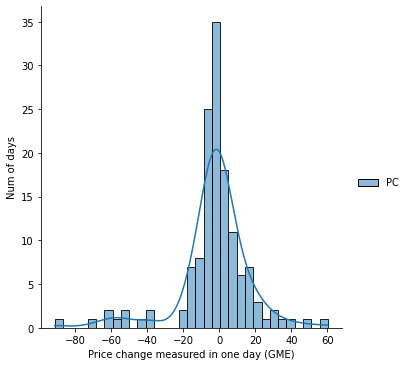

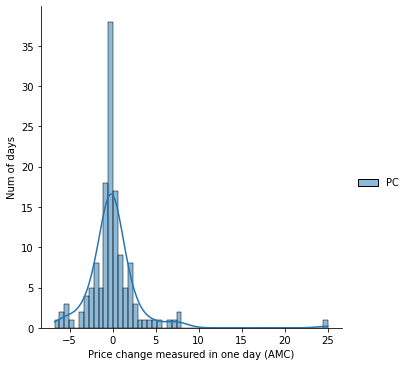

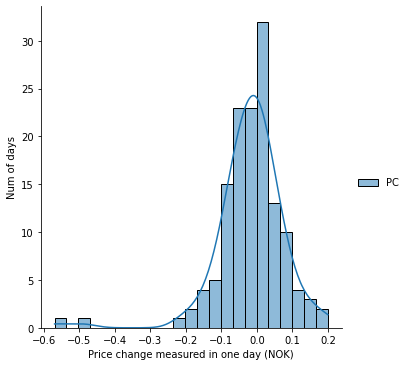

In [ ]:
#@title Price Change distribution graph
sns.displot(GME_label_df, kde=True).set_axis_labels("Price change measured in one day (GME)", "Num of days")
sns.displot(AMC_label_df, kde=True).set_axis_labels("Price change measured in one day (AMC)", "Num of days")
sns.displot(NOK_label_df, kde=True).set_axis_labels("Price change measured in one day (NOK)", "Num of days")

We can see that in our 3 chosen stocks, the major changes have been in the GME stock values- it has changes of over 40\$ in one day (and up to -90\$), while the largest change in AMC was 25\$, and for NOK -0.55\$.
We can see again that GME stock "behaves" radically.

###Amount of posts descriptions

First we'll plot a violin graph of each stock for the whole period:

In [ ]:
#@title Violin Graph of the whole period
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(yaxis_title="Posts in day")

fig.show()

We can see that because of few singles extra ordinary samples the graph gets shrunken.
As we saw before, our data starts with a very radical situation, where the number of comments is very high mainly in GME and AMC. After few days the distribution gets normal (as the *shortsqueeze* ends) as we can see in the violin graph that starts from day 10:

(We also cut part of AMC dates to show a more calm period in details)

In [ ]:
#@title Violin Graph from day 10
fig = go.Figure()
df_after_10days_GME = day_GME_df[10:]
df_after_10days_GME.name = day_GME_df.name
df_after_10days_AMC = day_AMC_df[10:90]
df_after_10days_AMC.name = day_AMC_df.name
df_after_10days_NOK = day_NOK_df[10:]
df_after_10days_NOK.name = day_NOK_df.name

for stock_df in [df_after_10days_GME, df_after_10days_AMC, df_after_10days_NOK]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(yaxis_title="Posts in day")


fig.show()

Now we can see that after the short squeeze was over, GME still had many days with a high amount of posts per day. AMC and NOK were reduced down to a small number of posts, which can make it difficult to predict their values based on posts. But, because of the high variance in the data, we are still struggling to draw significant conclusions from the data. So, we will present it again in a normalized logarithmic scale for looking at percentage differences between values instead of the actual differences:

In [ ]:
#@title Violin Graph from day 10 - Normalized log scaled posts in day
fig = go.Figure()
df_after_10days_GME = day_GME_df[10:]
df_after_10days_GME['log_posts_day_count']= np.log(df_after_10days_GME['posts_day_count'])
df_after_10days_GME['normalized_log_posts_day_count']= (df_after_10days_GME['log_posts_day_count']-df_after_10days_GME['log_posts_day_count'].mean()) / (df_after_10days_GME['log_posts_day_count'].std()+0.000001)
df_after_10days_GME.name = day_GME_df.name
df_after_10days_AMC = day_AMC_df[10:]
df_after_10days_AMC['log_posts_day_count']= np.log(df_after_10days_AMC['posts_day_count'])
df_after_10days_AMC['normalized_log_posts_day_count']= (df_after_10days_AMC['log_posts_day_count']-df_after_10days_AMC['log_posts_day_count'].mean()) / (df_after_10days_AMC['log_posts_day_count'].std()+0.000001)
df_after_10days_AMC.name = day_AMC_df.name
df_after_10days_NOK = day_NOK_df[10:]
df_after_10days_NOK['log_posts_day_count']= np.log(df_after_10days_NOK['posts_day_count'])
df_after_10days_NOK['normalized_log_posts_day_count']= np.log((df_after_10days_NOK['log_posts_day_count']-df_after_10days_NOK['log_posts_day_count'].mean()) / (df_after_10days_NOK['log_posts_day_count'].std()+0.000001))
df_after_10days_NOK.name = day_NOK_df.name

for stock_df in [df_after_10days_GME, df_after_10days_AMC, df_after_10days_NOK]:
  fig.add_trace(go.Violin(y=stock_df['normalized_log_posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(title="Normalized log scaled posts in day")
  fig.update_layout(yaxis_title="Value")
  fig.update_layout(xaxis_title="Stock")


fig.show()

Now, after presenting the data on a normalized logarithmic scale we can observe a phenomenon we have seen before, after using the FB prophet tool. GME and AMC exhibit similar behavior (with different volumes), while NOKs believer is different:
* Both GME and AMC's interquartile range in the adjusted logarithmic scale are almost the same while NOKs are lower
* Both GME and AMC normalized median and mean in the logarithmic scale are almost the same while NOKs are lower (the median is ~0.85 lower)
* NOK has a few significantly lower values.

In [ ]:
#@title Number of posts per stock
dict_posts_num = {}
for stock_df in stocks_df_list:
  dict_posts_num[stock_df.name] = len(stock_df)
fig = px.pie(union_df, values=dict_posts_num, names=dict_posts_num.keys())
fig.update_traces(textinfo='label+value')
fig.update_layout(hovermode=False, title={'text':'Posts number per stock',
        'y':0.95,
        'x':0.49,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

GME has the largest numbers. More posts, bigger changes in stock value and higher max score. Then comes AMC and then NOK.

Therefor, we should analyze and measure each stock according to itself, and not to set general thresholds and limits that applies to all stocks.

###Analyzing pairwise relationships between features

In [ ]:
#@title Pairplot graph
fig = px.scatter_matrix(union_day_df, dimensions=["score", "comms_num", "posts_day_count", "sentiment"], color='stock_name', hover_data=["timestamp"])
fig.show()

We can infer few conclusions from the graphs above:


*   As we saw before- GME stock had "more from everything" than AMC and NOK (more posts, total scores..). More data can help for predicting better results.
*   There are few single days that have an extra ordinary data, like a huge number of comments or a big total scores number. Adding the date to each label reveal that they were part of the big *short squeeze* that happened in the end of January 2021.
*   From the sentiment graphs- usually the sentiment of days with a large total sentiment value  is positive. That is, when there are many posts or many comments for posts, usually it goes with a positive post.

###Forecasting values by trends in the stock with FB prophet

We can use FB prophet to approximate past stock prices for predicting future values based on historical trends.
By fitting a linear function, the FB prophet can predict results only by the values we are trying to predict (only the explained variable).

We are testing whether the trend of the stock can be interpolated based solely on its value

#### GME before the "short squeeze"
First, we try to forecast the values of the period after 01/08/2021 (GME's "short squeeze") by interpolating the 3 years before:

In [ ]:
#@title without the actual values :

m, forecast, y_gme_df = FB_prophet('GME', '2016-01-01', '2021-01-08', '2021-08-16',365)
fig = plot_plotly(m, forecast)
fig

08:48:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing


We can see that the model can predict well the trends (specific spikes in the values) of this era. Using them, it tries to predict the following half a year.

In [ ]:
#@title with the actual values as reference
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))
config = dict({"scrollZoom":True})
fig.show(config=config)

But, as we can see from the graph above, the next half a year is totally unpredicted by the trends of the years before. 
We know that at the beginning of 2021 a big "short squeeze" took place. 
So, we can see that after it occurred the trends in the stock's value changed and couldn't be predicted by the era before it. 
So, we will try to determine if we can predict spikes in the values by combining data from the time before the "short squeeze" and after it.

#### GME before and after the "short squeeze" 
Furthermore, due to the misfit of the year's before 2021 with 2021's first half a year, we interpolate the values of the period of 16/05/2021 - 16/08/2021 by referring to the data since 01/01/2016.
The point is to see if trends before and after the short squeeze can be related.

In [ ]:
#@title with the actual values as refference :

m, forecast, y_gme_df = FB_prophet('GME', '2016-01-01', '2021-05-16', '2021-08-16',200)
fig = plot_plotly(m, forecast)
cutoff_date = '2021-05-16'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))


fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))



08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing


Observe that the updated interpolation over the combined eras is less accurate than that before the "short squeeze" (predict many unoccurring spikes). Additionally, after the "short squeeze" it predicts only general trends and not the actual rises and drops in value. So, we will try to see if only by fitting data from the time after the "short squeeze" the values can be approximated well and the model can predict actual and future spikes in the stock.

#### GME only after the "short squeeze" 
Last, we try to forecast the values of the period of 16/05/2021 - 16/08/2021 by interpulating with the data since 08/01/2021:

In [ ]:
#@title without the actual values :

m, forecast, y_gme_df = FB_prophet('GME', '2021-01-08', '2021-05-10', '2021-08-16',200)
fig = plot_plotly(m, forecast)
cutoff_date = '2021-05-16'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))

08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing


By looking at the above graph, we can see that, in comparison to the era before the "short squeeze", the era after the "short squeeze" can't be interpolated and modeled with reliable results that can allow us to correctly predict the spikes in the stock. We can conclude from this analysis that the "short squeeze" in GME is an event that changed the behavior of the stock. Since the new behavior is more difficult to predict using only the explained variable (stock's value), it will be interesting to see if we can approximate it using reddit posts as an explanatory variable in this period of time. Hence, if we succeed in doing so over the second period but not the first, this implies that there is a connection between fluctuation in the stock's value and a substantial shock in its price to reddit as an explanation variable.

#### AMC and NOK since 2016  
Analysis of the other stocks of the project - NOK and AMC

In [ ]:
#@title AMC :

m, forecast, y_gme_df = FB_prophet('AMC', '2016-01-01', '2021-01-08', '2021-08-16',365)
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]


fig = plot_plotly(m, forecast)
fig.add_trace(go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'))


08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#@title NOK :

m, forecast, y_gme_df = FB_prophet('NOK', '2016-01-01', '2021-01-08', '2021-08-16',365)
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]


fig = plot_plotly(m, forecast)
fig.add_trace(go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'))


08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing


In comparing AMC and NOK shares, we can observe the same rises and drops in value that followed the GME short squeeze of the AMC stock.
On the other hand, we don't see it over NOK. After the short squeeze, both GME and AMC became more volatile, while NOK remained stable. 
The fluctuation of the stock values in this time period, combined with the high volume of traffic on Reddit, suggests that traffic on Reddit has become an explanation for the stock values.

###Normalized Sentiment VS Value

we see a partly correlation between the normalized sentiment and price changes

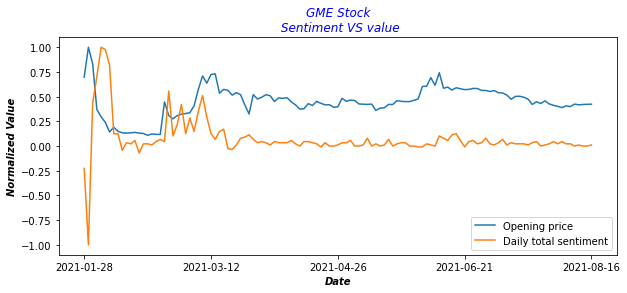

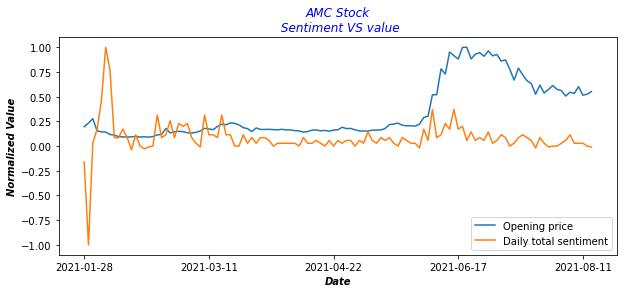

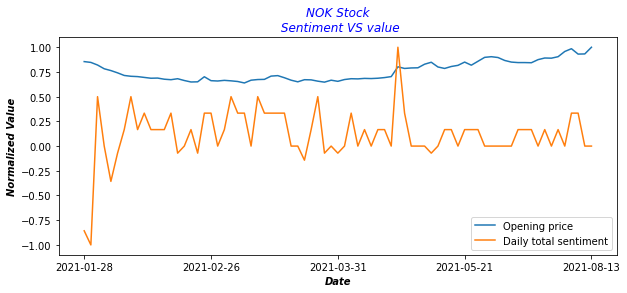

In [ ]:
#@title Normalized Sentiment VS Value Graphs
normialized_sentiment_value_show(GME_df, GME_stocks_df, "GME")
normialized_sentiment_value_show(AMC_df, AMC_stocks_df, "AMC")
normialized_sentiment_value_show(NOK_df, NOK_stocks_df, "NOK")

We can see that significant price increasments in GME and AMC (blue curve) are usually accompanied by a strong positive sentiment, and the big drop in GME at the beginning of February 2021 was accompanied by a strong negative sentiment.

In contrast- NOK stock value seems to be more insensitive to sentiments, even though the sentiment differents are less radical. The strongest sentiment for NOK does accompanied by a small value increasment.

###Textual data analysis

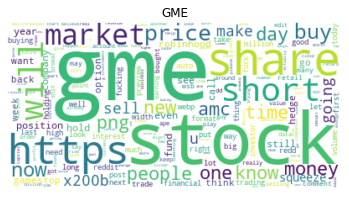

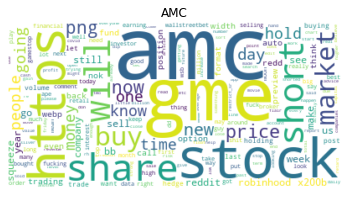

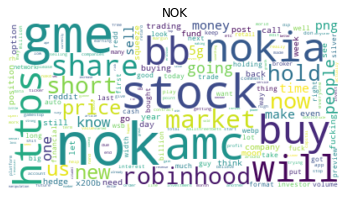

In [ ]:
#@title Semantic Distribution
create_wordclouds([GME_df, AMC_df, NOK_df])

Looking at the most common words, we can see that most of them are neutral, and some are even not related to the post saying (like 'http' and 'png').

We cannot say rather we should consider the sentiment feature as a main feature for predicting value change or not, but it worth to test the effect of the post's nerative on our results mainly when it's a strong one- means that in one day, many posts had a clear strong sentiment.

In [ ]:
#@title Average lexical richness
averages = []
AMC_text_flatten = nltk.Text([x for xs in create_text_str(AMC_df, combined=False) for x in xs])
NOK_text_flatten = nltk.Text([x for xs in create_text_str(NOK_df, combined=False) for x in xs])
GME_text_flatten = nltk.Text([x for xs in create_text_str(GME_df, combined=False) for x in xs])
for df_text, df in zip((GME_text_flatten, AMC_text_flatten, NOK_text_flatten),(GME_df, AMC_df, NOK_df)):
  average = len(set(df_text))/len(df_text)
  print(f"{df.name} lexical richness is {average}")

GME lexical richness is 0.04537012411592098
AMC lexical richness is 0.06223169775826932
NOK lexical richness is 0.09001998631322768


We could expect for social media posts to have low lexical richness, since many words repeats themselves (also the stocks names) and many times the are a lot of posts with same meaning, using same words.

In [ ]:
#@title Similar words
print("Words with similar range of context to GME:")
GME_text_flatten.similar('gme', 30)
print("\nWords with similar range of context to AMC:")
AMC_text_flatten.similar('amc', 30)
print("\nWords with similar range of context to NOK:")
NOK_text_flatten.similar('nok', 30)

Words with similar range of context to GME:
the it this and that you shares to a amc is gamestop in i but all what
stock robinhood for them at on now of there more us buy they

Words with similar range of context to AMC:
gme the it and this that nok shares you bb is buy hold in on robinhood
to now a i more all what stock them not but there stocks us

Words with similar range of context to NOK:
gme amc bb it nokia and this the buy hold robinhood that is shares in
on you stock now all to not more what nakd why if there or for


We can get 2 main insights from the similar context above.
The first is that often the stocks appear together in the same context. Mainly NOK, usually comes along with the 2 other stocks, and also with BB stock (BlackBerry) that also participant in the famous shortsqueeze.

The second is that many posts include the words "buy" and "hold", as expected- a major goal of the posts is to encourage people to take some action with those stocks.

In [ ]:
#@title Collocations
GME_text_flatten.collocation_list(num=30, window=3)

[('hedge', 'funds'),
 ('short', 'interest'),
 ('financial', 'advice'),
 ('wall', 'street'),
 ('gme', 'amc'),
 ('hedge', 'fund'),
 ('diamond', 'hands'),
 ('short', 'squeeze'),
 ('retail', 'investors'),
 ('financial', 'advisor'),
 ('pop', 'pop'),
 ('per', 'share'),
 ('market', 'cap'),
 ('gamma', 'squeeze'),
 ('last', 'week'),
 ('long', 'term'),
 ('buy', 'gme'),
 ('market', 'manipulation'),
 ('ryan', 'cohen'),
 ('melvin', 'capital'),
 ('short', 'positions'),
 ('call', 'options'),
 ('loss', 'porn'),
 ('short', 'sellers'),
 ('ladder', 'attacks'),
 ('paper', 'hands'),
 ('amc', 'nok'),
 ('share', 'price'),
 ('make', 'money'),
 ('market', 'makers')]

Again, we see that the stocks often goes together, since 'gme, amc', and 'amc, nok' appears.

But here we can also get a little feeling of the shortsqueeze on GME stock, noticing that one of the pairs is 'buy, gme'. Probably  during the shortsqueeze there were many posts that encourged people to buy GME stocks.

In [ ]:
#@title Vocabulay size
print("GME vocab size-", len(GME_text_flatten.vocab()))
print("AMC vocab size-", len(AMC_text_flatten.vocab()))
print("NOK vocab size-", len(NOK_text_flatten.vocab()))

GME vocab size- 123339
AMC vocab size- 49622
NOK vocab size- 19863


We can infer that the size differences are due to the size differences of the data sets.

##Textual Feature Extraction

In [ ]:
corpus = list(create_text_str(GME_df))
tfidf = TfidfVectorizer(max_features = 6000) 
tfidf.fit(corpus)
tfidf_features = tfidf.transform(corpus)

NameError: ignored

##Brute Force Algorithms

### Analitical Regressions

First, we used linear and logistic regression to analyze the connection between the features and the stock's price change. 

#### Linear Regression

#####First Model

We started with a simple linear regression model:

$PC_{day_{i+1}}= α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}$


while:

* $score_{day_i}$ : sum of scores of all posts in day i over GME in r/wallstreetbets channel. the score of a post is determined by the number of upvotes (likes) minus the number of downvots (dislikes) upon the post .

* $comms_{day_i}$ : sum of all the comments over all the posts in day i over GME in r/wallstreetbets channel

* $posts_{day_i}$ : number of posts posted in day i over GME in r/wallstreetbets channel

* $sentiment_{day_i}$ : sum of all sentiments score determined by VADER of posts posted in day i over GME in r/wallstreetbets 

* $PC_{day_{i+1}}$ : Price changes (open - close) in the GME stock's value on day i+1 (predicted variable)




In [ ]:
linear_df = day_before.dropna().copy(deep=True)
linear_df.drop(['timestamp'], axis=1, inplace=True)
model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

We can see high levels of significance in both t values and F values. Therefore, the features have a high probability of being relevant for the predictions. But, the $R^2$ score is 0.264 which is low. So, the simple model isn't complex enough to predict the PC with efficient accuracy. To improve accuracy, we will try a more complex model with more features.


#####second model

$PC_{day_{i+1}}=α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}+α_4*score_{day_i}*sentiment_{day_i}+α_5*comms_{day_i}*sentiment_{day_i}+α_6*posts_{day_i}*sentiment_{day_i}+α_7*posts_{day_i}^2+α_8*sentiment_{day_i}^2+α_9*score_{day_i}^2+α_{10}*comms_{day_i}^2$

We added interactions between every two initial features and polyinomial features to each feature in order to allow the model to integrate interactions between features and polynomial effects. 

In [ ]:
linear_df['sentiment*score'] = linear_df['sentiment']*linear_df['score']
linear_df['sentiment*comms_num'] = linear_df['sentiment']*linear_df['comms_num']
linear_df['posts_day_count*sentiment'] = linear_df['posts_day_count']*linear_df['sentiment']
linear_df['posts_day_count**2'] = linear_df['posts_day_count']**2
linear_df['sentiment**2'] = linear_df['sentiment']**2
linear_df['score**2'] = linear_df['score']**2
linear_df['comms_num**2'] = linear_df['comms_num']**2

model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

In terms of statistical significance, the F value is still significant within a confidence interval of 95%. So, the model is relevant for predicting PC value. But, the T value of every feature except the $posts^2$ is not high enough. So in terms of analysing the features, we can only assume that the influence of the number of posts in a day isn't linear. And, can't know the exact relevance of the other features in the model.
We can also see an improvement in the accuracy score ($R^2$) to 0.357 as we wanted to achieve.

####Logistic Regression

After getting maximum accuracy of 0.357 with the linear regression we turn to a logistic regression model. With it we can only classify to classes - negative, positive or natural PC value. So we are taking the second, more complax model, from before and change the predicted values into classes.

In [ ]:
logistic_df = linear_df.copy(deep=True)
logistic_df['PC']= logistic_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
logistic_df.dropna(inplace=True)
x = logistic_df.drop(['PC'], axis=1)
y = logistic_df['PC']
clf = LogisticRegression(random_state=0).fit(x, y)
clf.score(x, y)

We have a significant improvement in the accuracy score from the linear model (0.56 VS 0.357). Thus, simply classifying the trend in a stock's value is likely easier than trying to predict the exact price movements. 

###Classifiers

After using analitical regressions over the data we turn to use a classical simple classfiing algorithms:
* Random Forest (RF)
* k nearest neighbors (KNN)
* Support vector machine (SVM)

In order to let the algorithms extract features from the clean data frame, we return to the clean data frame with it classifying to classes version.

In [ ]:
cls_df = day_before.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
cls_df.sample(n=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

####Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

####SVM

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel="rbf", C=1, probability=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

####KNN

In [ ]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

We are getting the highest score with KNN (o.75 VS 0.625 and 0.542).

####KNN  roc and report:

To learn more about the problem, we are analyzing the most accurate classifier results (KNN):



In [ ]:
y_pred = knn.predict(X_test)
knn_cf_matrix, knn_cl_report, knn_acc_score = get_metrices(y_test,y_pred)
print(knn_cl_report)

In [ ]:
roc_curve_PC(knn, X_train, y_train)

We can see that the algorithm can predict with more precision negative trends in the stock price than positive ones. 
This can suggest a stronger relationship between a decrease in stock value and the reddit posts than an increase in stock value. But, it could also be connected to the fact that our database is limited to a specific period and specifically lacks the initiation of the GME frenzy.ueese.

##Conclusion

In this Project Suggestion, we discussed the connections between trends on the social media platform - Reddit and specific stocks values. 
We used a premade Kaggle dataset and processed it to our needs by hard-coded actions and premade libraries such as VADER. 
We defined the question we intend to investigate - **whether we can predict the value of the stock tomorrow based on today's data** 

We applied some classical algorithms to the data in order to show that the connection may be causal or at least correlative.

As a result, we plan to continue to study it in our project. 
This will enable us to have a better grasp of the connections in our question field and to get better accurate results

###Looking forward to the project:
we intend to do the following:

*   using the data from all the 3 stocks for the classification
*   trying deep neural network over the VADER sentiment and the Doc2Vec vectors
*   augmenting the dataset by Reddit API - specifically to the period before the GME's short squeeze. As we mentioned, our data from kaggle starts in the middle of the big hype of the Meme-Stocks, and for that reason it is many times distorted for predictions. In some cases it is better to skip the first days of sampling to get a more stable prediction.
*   extracting more features from the links, photos, and videos from the posts
*   adding more stocks than GME, AMC, and NOK
